<a href="https://colab.research.google.com/github/mangarovska/MovieRecommenderSystem/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing libraries :**

In [1]:
import numpy as np # for working with arrays and matrices
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import os
import seaborn as sns

!pip install surprise
import surprise
from surprise import SVD
from surprise import Reader, Dataset

import pickle

!pip install -q streamlit
import streamlit as st

!pip install -q pyngrok
from pyngrok import ngrok

# from flask import Flask, request, jsonify, render_template
# import requests
# from flask_ngrok import run_with_ngrok

In [2]:
# !pip install flask-ngrok
# !ngrok authtoken '2V4wp8LfiNIuV6Wf8r3vOjLoH8a_3gmW3FAhzuP3mNpd4nPbX'

#**Importing dataframe :**

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
!gdown 1eZGrMvkpmSU6Fy3Y7SS_Mhd3fHc1RftT # the folder

movies_path = "/content/drive/My Drive/MM/ml-latest-small/movies.csv"
movies_df = pd.read_csv(movies_path)

movies_df.head(5)

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1eZGrMvkpmSU6Fy3Y7SS_Mhd3fHc1RftT 



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print('Shape of this dataset :', movies_df.shape)

Shape of this dataset : (9742, 3)


In [6]:
ratings_path = "/content/drive/My Drive/MM/ml-latest-small/ratings.csv"
ratings_df = pd.read_csv(ratings_path)

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
print('Shape of this dataset :', ratings_df.shape)

Shape of this dataset : (100836, 4)


In [8]:
tags_path = "/content/drive/My Drive/MM/ml-latest-small/tags.csv"
tags_df = pd.read_csv(tags_path)

tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
print('Shape of this dataset :', tags_df.shape)

Shape of this dataset : (3683, 4)


#**Exploring the dataset :**

In [10]:
# merge movies and ratings
merged_df = pd.merge(ratings_df, movies_df, on="movieId", how='inner')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [11]:
# checking for duplicates
dup_bool = merged_df.duplicated(['movieId','userId'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [12]:
# this means no user gave more than 1 rating for the same movie

In [13]:
print('Shape of this dataset :', merged_df.shape)

Shape of this dataset : (100836, 6)


In [14]:
# merged movies ratings and tags
# merge the tags information into movies DataFrame
movies_with_tags = pd.merge( merged_df, tags_df, on=["movieId", "userId"], how='left')
movies_with_tags.head(10)

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
8,27,1,3.0,962685262,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
9,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN


In [15]:
print('Shape of this dataset :', movies_with_tags.shape) # number is bigger because user can put multiple tags

Shape of this dataset : (102677, 8)


In [16]:
# remove the timestamp columns
movies_with_tags.drop(columns=["timestamp_x", "timestamp_y"], inplace=True)
movies_with_tags.head(10)

,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
5,18,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
6,19,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
7,21,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
8,27,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
9,31,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN


In [17]:
print('Shape of this dataset :', movies_with_tags.shape)

Shape of this dataset : (102677, 6)


In [18]:
# join tags from certain user
# ensure 'tag' column contains only strings, and handle missing values
movies_with_tags['tag'] = movies_with_tags['tag'].astype(str)

# Join tags for the same user and movie
movies_with_tags = movies_with_tags.groupby(['userId', 'movieId'])['tag'].apply(', '.join).reset_index()
movies_with_tags.head(10)

,userId,movieId,tag
0,1,1,nan
1,1,3,nan
2,1,6,nan
3,1,47,nan
4,1,50,nan
5,1,70,nan
6,1,101,nan
7,1,110,nan
8,1,151,nan
9,1,157,nan


In [19]:
print('Shape of this dataset :', movies_with_tags.shape)

Shape of this dataset : (100836, 3)


In [20]:
nan_count = movies_with_tags['tag'].str.contains('nan', case=False, na=False).sum()
print("Number of 'nan' occurrences in the 'tag' column:", nan_count)

Number of 'nan' occurrences in the 'tag' column: 99218


In [21]:
# remove rows with 'nan' in tag column
movies_with_tags = movies_with_tags[movies_with_tags['tag'] != 'nan']
movies_with_tags.head(10)

,userId,movieId,tag
241,2,60756,"funny, Highly quotable, will ferrell"
250,2,89774,"Boxing story, MMA, Tom Hardy"
254,2,106782,"drugs, Leonardo DiCaprio, Martin Scorsese"
1019,7,48516,way too long
1808,18,431,"Al Pacino, gangster, mafia"
1866,18,1221,"Al Pacino, Mafia"
1999,18,5995,"holocaust, true story"
2077,18,44665,twist ending
2093,18,52604,"Anthony Hopkins, courtroom drama, twist ending"
2179,18,88094,"britpop, indie record label, music"


In [22]:
print('Shape of this dataset :', movies_with_tags.shape) # number of movies with tags

Shape of this dataset : (1635, 3)


In [23]:
merged_df.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,27,1,3.0,962685262,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [24]:
print('Shape of this dataset :', merged_df.shape)

Shape of this dataset : (100836, 6)


In [25]:
# fill missing tag values with an empty string if there are NaNs
merged_df = pd.merge( merged_df, movies_with_tags, on=["movieId", "userId"], how='left')
merged_df['tag'] = merged_df['tag'].fillna('')
merged_df.head(10)

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
8,27,1,3.0,962685262,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
9,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,


In [26]:
print('Shape of this dataset :', merged_df.shape) # those with mo tags have empty string in that column

Shape of this dataset : (100836, 7)


In [27]:
# checking if there are any missing values (NaN, None)
merged_df.isna().any()

userId       False
movieId      False
rating       False
timestamp    False
title        False
genres       False
tag          False
dtype: bool

In [28]:
merged_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

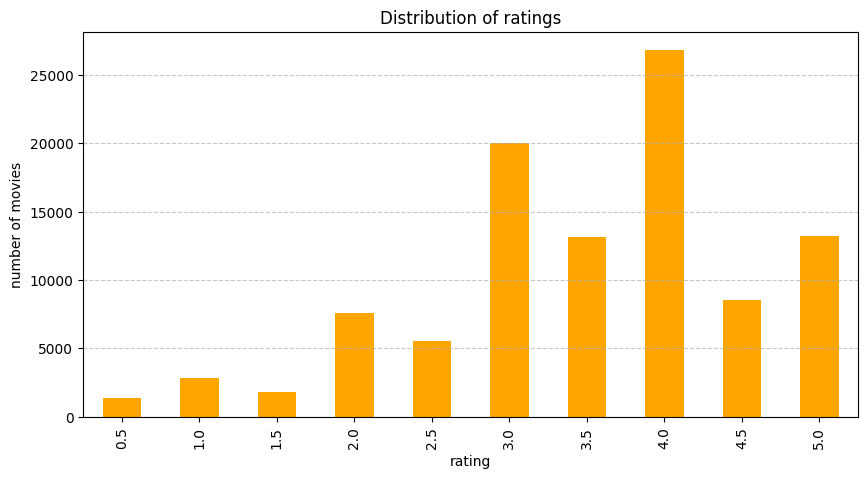

In [29]:
# distribution of ratings
#print(merged_df['rating'].describe())
pd.Series(merged_df['rating']).value_counts().sort_index().plot(kind='bar', figsize=(10, 5), color="orange")
plt.title("Distribution of ratings")
plt.ylabel("number of movies")
plt.xlabel("rating")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
print(" Total data :")
print("-"*42)
print(" Total number of Ratings        :", merged_df.shape[0])
print(" Total number of unique Users   :", len(np.unique(merged_df.userId)))
print(" Total number of unique Movies  :", len(np.unique(merged_df.movieId)))

 Total data :
------------------------------------------
 Total number of Ratings        : 100836
 Total number of unique Users   : 610
 Total number of unique Movies  : 9724


In [31]:
# get the top 10 most avtive user
print(" Top 10 most active users and number of ratings :")
print("-"*52)
sorted_by_users = merged_df.groupby('userId')['movieId'].count().sort_values(ascending=False)
top_10 = sorted_by_users.index[:10].tolist()

print("user IDs : ", top_10)  # the userIds
print ("Ratings : ", sorted_by_users.values[:10]) # how many ratings

 Top 10 most active users and number of ratings :
----------------------------------------------------
user IDs :  [414, 599, 474, 448, 274, 610, 68, 380, 606, 288]
Ratings :  [2698 2478 2108 1864 1346 1302 1260 1218 1115 1055]


In [32]:
# get the top 10 most rated movies
sorted_by_movies = merged_df.groupby('movieId')['userId'].count().sort_values(ascending=False)
top_10_movies = sorted_by_movies.head(10) # just the movie IDs

top_10_movies_df = pd.DataFrame({'movieId': top_10_movies.index, 'number_of_ratings': top_10_movies.values})

# merge with movies_df to get movie titles
top_10_movies_with_titles = pd.merge(top_10_movies_df, movies_df, on='movieId')

print(" Top 10 most rated movies along with the number of ratings : ")
print("-"*63)
print(top_10_movies_with_titles[['title', 'number_of_ratings']].to_string(index=False, justify={'number_of_ratings': 'right'}))

 Top 10 most rated movies along with the number of ratings : 
---------------------------------------------------------------
                                    title  number_of_ratings
                      Forrest Gump (1994)                329
         Shawshank Redemption, The (1994)                317
                      Pulp Fiction (1994)                307
         Silence of the Lambs, The (1991)                279
                       Matrix, The (1999)                278
Star Wars: Episode IV - A New Hope (1977)                251
                     Jurassic Park (1993)                238
                        Braveheart (1995)                237
        Terminator 2: Judgment Day (1991)                224
                  Schindler's List (1993)                220


In [33]:
# removing rows with the genre "(no genre listed)" since there are 34 of them
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']

In [34]:
genres_split = movies_df['genres'].str.split('|')
all_genres = genres_split.explode()
unique_genres = all_genres.unique()

print("Unique Genres : ", len(unique_genres))
print("-"*20)
for i, genre in enumerate(unique_genres, start=1):
    print(f"{i}. {genre}")

Unique Genres :  19
--------------------
1. Adventure
2. Animation
3. Children
4. Comedy
5. Fantasy
6. Romance
7. Drama
8. Action
9. Crime
10. Thriller
11. Horror
12. Mystery
13. Sci-Fi
14. War
15. Musical
16. Documentary
17. IMAX
18. Western
19. Film-Noir


In [35]:
# an empty DataFrame to store genre counts
genre_counts_df = pd.DataFrame(columns=['Genre', 'Count'])

for genre in unique_genres:
    genre_count = (movies_df['genres'].str.split('|')
                   .apply(lambda x: genre in x)
                   .sum())
    genre_counts_df = pd.concat([genre_counts_df, pd.DataFrame({'Genre': [genre], 'Count': [genre_count]})])

genre_counts_df = genre_counts_df.sort_values(by='Count', ascending=False) # sort for the legend

# genres with less than 1000 counts have a grey color
colors = ['#A0E045' if count >= 1000 else '#abaeab' for count in genre_counts_df['Count']]

fig = px.bar(
    genre_counts_df,
    x='Genre',
    y='Count',
    title='Most Popular Genres',
    color=genre_counts_df['Genre'],
    color_discrete_sequence=colors,
    labels={'Genre': 'Genre'},  # legend label is 'Genre'
)

fig.update_xaxes(categoryorder='total ascending')
fig.show()

#**Collaborative Filtering :**
### User-Based ( by ratings from other users )


In [36]:
# maps individual user ratings into rows against each movie as a column
# the intersection is the rating of the user fot the movie
df = merged_df.pivot_table(index='userId', columns='title', values='rating')

# keep only movies that had at least 8 ratings
# df = df.dropna(thresh=8, axis=1)

df.fillna(0, inplace=True)
df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# a table of just the IDs is more suitable for what we're trying to do
df_ids = ratings_df.pivot_table(values='rating',columns='userId',index='movieId').fillna(0)
df_ids.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
print('Shape of the first pivot table :', df.shape)
print('Shape of the second pivot table :', df_ids.shape)

Shape of the first pivot table : (610, 9719)
Shape of the second pivot table : (9724, 610)


In [39]:
# just to make sure that all Nan containing rows are deleted. (there are none, but still)
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


###**Pivot table of ratings given by users to movies**

In [40]:
df_ids.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_ids.shape

(9724, 610)

### **Machine Learning Model training for Recommending movies based on users ratings**

In [42]:
from sklearn.neighbors import NearestNeighbors
nn_algo = NearestNeighbors(metric='cosine')
nn_algo.fit(df_ids)

NearestNeighbors(metric='cosine')

In [43]:
class Recommender_collab:
    def __init__(self):
        # this list will stored movies that called atleast ones using recommend_on_movie method
        self.hist = []
        self.ishist = False # check if history is empty

    # recommend movies based on a movie that passed as the parameter
    def recommend_on_movie(self,movie,n_reccomend = 5):
        self.ishist = True
        movieid = int(movies_df[movies_df['title']==movie]['movieId'])
        self.hist.append(movieid)
        distance,neighbors = nn_algo.kneighbors([df_ids.loc[movieid]],n_neighbors=n_reccomend+1)
        movieids = [df_ids.iloc[i].name for i in neighbors[0]]
        recommeds = [str(movies_df[movies_df['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in movieids if mid not in [movieid]]
        return recommeds[:n_reccomend]

    # recommend movies based on history stored in self.hist list
    def recommend_on_history(self,n_reccomend = 5):
        if self.ishist == False:
            return print('No history found')
        history = np.array([list(df_ids.loc[mid]) for mid in self.hist])
        distance,neighbors = nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        movieids = [df_ids.iloc[i].name for i in neighbors[0]]
        recommeds = [str(movies_df[movies_df['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in movieids if mid not in self.hist]
        return recommeds[:n_reccomend]


In [44]:
# init the Recommender Object
recommender = Recommender_collab()

In [45]:
# no history found yet
recommender.recommend_on_history()

No history found


In [46]:
# recommendation based on this movie
recommender.recommend_on_movie('GoldenEye (1995)')

['Die Hard: With a Vengeance (1995)',
 'True Lies (1994)',
 'Clear and Present Danger (1994)',
 'Speed (1994)',
 'Batman (1989)']

In [47]:
# recommendation based on past watched movies, this time 1 movie in history
recommender.recommend_on_history()

['Die Hard: With a Vengeance (1995)',
 'True Lies (1994)',
 'Clear and Present Danger (1994)',
 'Speed (1994)',
 'Batman (1989)']

In [48]:
recommender.recommend_on_movie('Pocahontas (1995)')

['Beauty and the Beast (1991)',
 'Casper (1995)',
 'Lion King, The (1994)',
 'Aladdin (1992)',
 'Snow White and the Seven Dwarfs (1937)']

In [49]:
recommender.recommend_on_history()

['Aladdin (1992)',
 'Speed (1994)',
 'Die Hard: With a Vengeance (1995)',
 'Lion King, The (1994)',
 'Jurassic Park (1993)']

In [50]:
recommender.recommend_on_movie('Waiting to Exhale (1995)')

['Before and After (1996)',
 'Gordy (1995)',
 'Walking Dead, The (1995)',
 'Bliss (1997)',
 'Nothing Personal (1995)']

In [51]:
recommender.recommend_on_history()

['Aladdin (1992)',
 'Speed (1994)',
 'Die Hard: With a Vengeance (1995)',
 'Jurassic Park (1993)',
 'Batman Forever (1995)']

#**Web interface (for Paerson correlation)**

###**Rocommendation using Paerson Correlation**

In [52]:
df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df.shape

(610, 9719)

In [54]:
# we can use the Pearson correlation to calculate the similarity between movies
# The Pearson method treats each movie (column) as a vector containing user rating values and determines how close/similar a movie is to the other ones
df_similarity = df.corr(method='pearson')
# similarity matrix below
# each movie is perfectly similar to itself

# store the data for later to be used in building the API maybe
df_similarity.to_csv('movie_similarity.csv')
df_similarity.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,0.135943,-0.004325,...,-0.001642,0.339935,0.542247,0.706526,-0.001642,-0.007675,0.134327,0.325287,-0.008185,-0.001642
'Hellboy': The Seeds of Creation (2004),-0.001642,1.000000,0.706526,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Round Midnight (1986),-0.002324,0.706526,1.000000,-0.002324,-0.003191,-0.002324,0.170199,-0.002324,-0.014958,-0.006121,...,-0.002324,-0.006495,-0.003975,-0.003289,-0.002324,-0.010863,-0.010961,-0.005087,-0.011585,-0.002324
'Salem's Lot (2004),-0.001642,-0.001642,-0.002324,1.000000,0.857269,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Til There Was You (1997),-0.002254,-0.002254,-0.003191,0.857269,1.000000,-0.002254,-0.008797,-0.002254,-0.014510,-0.005938,...,-0.002254,-0.006301,-0.003856,-0.003191,-0.002254,-0.010538,-0.010632,-0.004935,-0.011238,-0.002254


In [55]:
def paerson_rec (movie):
  # accessing the corresponding movie column
  similarityScores = df_similarity[movie]

  # sorting the similarity scores from highest to lowest to get the top 30 movies
  s = similarityScores.sort_values(ascending=False)[1:10]
  return s

In [56]:
movieLiked = 'Waiting to Exhale (1995)'
paerson_rec(movieLiked)

title
Before and After (1996)                            0.544701
Georgia (1995)                                     0.454782
Haunted World of Edward D. Wood Jr., The (1996)    0.454782
Sum of Us, The (1994)                              0.454782
Nina Takes a Lover (1994)                          0.454782
Bliss (1997)                                       0.454782
Last Dance (1996)                                  0.454782
Federal Hill (1994)                                0.454782
Jefferson in Paris (1995)                          0.454782
Name: Waiting to Exhale (1995), dtype: float64

###**The interface**

In [57]:
pickle.dump(movies_df, open('movies_list.pkl', 'wb'))
pickle.dump(df_similarity, open('sim.pkl', 'wb'))
pickle.load(open('movies_list.pkl', 'rb'))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [58]:
pickle.load(open('sim.pkl', 'rb')) # the corelation matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,0.135943,-0.004325,...,-0.001642,0.339935,0.542247,0.706526,-0.001642,-0.007675,0.134327,0.325287,-0.008185,-0.001642
'Hellboy': The Seeds of Creation (2004),-0.001642,1.000000,0.706526,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Round Midnight (1986),-0.002324,0.706526,1.000000,-0.002324,-0.003191,-0.002324,0.170199,-0.002324,-0.014958,-0.006121,...,-0.002324,-0.006495,-0.003975,-0.003289,-0.002324,-0.010863,-0.010961,-0.005087,-0.011585,-0.002324
'Salem's Lot (2004),-0.001642,-0.001642,-0.002324,1.000000,0.857269,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Til There Was You (1997),-0.002254,-0.002254,-0.003191,0.857269,1.000000,-0.002254,-0.008797,-0.002254,-0.014510,-0.005938,...,-0.002254,-0.006301,-0.003856,-0.003191,-0.002254,-0.010538,-0.010632,-0.004935,-0.011238,-0.002254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),-0.007675,-0.007675,-0.010863,-0.007675,-0.010538,-0.007675,0.187953,0.212646,0.053614,0.115396,...,-0.007675,-0.021449,-0.013126,-0.010863,-0.007675,1.000000,0.163022,-0.016800,0.138611,-0.007675
xXx (2002),0.134327,-0.007744,-0.010961,-0.007744,-0.010632,-0.007744,0.062174,-0.007744,0.241092,-0.000060,...,0.063291,0.291410,0.163464,0.240394,-0.007744,0.163022,1.000000,0.259049,0.065673,-0.007744
xXx: State of the Union (2005),0.325287,-0.003594,-0.005087,-0.003594,-0.004935,-0.003594,-0.014025,-0.003594,0.139511,-0.009467,...,-0.003594,0.376455,0.172818,0.227658,-0.003594,-0.016800,0.259049,1.000000,-0.017917,-0.003594


In [59]:
%%writefile app.py
import streamlit as st
import pickle
import requests
import re

TMDB_API_KEY = 'cffe31114d613bfc217edaaf17d9051e'

def clean_movie_title(title):
    # Remove year
    cleaned_title = re.sub(r'\(\d{4}\)', '', title).strip()

    # Check if the title ends with ", The"
    if cleaned_title.endswith(", The"):
        # Move "The " to the front
        cleaned_title = "The " + cleaned_title[:-5]

    return cleaned_title

def fetch_movie_id(title):
    try:
        cleaned_title = clean_movie_title(title)
        url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_API_KEY}&query={cleaned_title}"
        data = requests.get(url)
        data = data.json()
        if data["results"]:
            # Return the movie ID of the first result
            return data["results"][0]["id"]
    except Exception as e:
        st.error(f"Error fetching movie ID: {e}")
    return None

def fetch_poster(movie_id):
    try:
        url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={TMDB_API_KEY}"
        data = requests.get(url)
        data = data.json()
        poster_path = data["poster_path"]
        full_path = f"https://image.tmdb.org/t/p/w500{poster_path}"
        return full_path
    except Exception as e:
        st.error(f"Error fetching poster: {e}")
    return None

# Load movie data and similarity matrix
movies = pickle.load(open("movies_list.pkl", 'rb'))
s_matrix = pickle.load(open("sim.pkl", 'rb'))

movies_list = movies['title'].values

st.header("Movie Recommender System :sunglasses:")
selected = st.selectbox("Select movie from dropdown", movies_list)

def paerson_rec (movie):
    similarityScores = s_matrix[movie]
    s = similarityScores.sort_values(ascending=False)[1:6]
    return s

if st.button("Recommend"):
    movie_name = paerson_rec(selected)

    # poster images
    poster_width = 150
    poster_height = 250

    default_poster_path = '/content/drive/My Drive/MM/no_poster2.jpg'  # Change to your default poster path

    col1, col2, col3, col4, col5 = st.columns(5)

    for i, rec_movie in enumerate(movie_name.index, start=1):
        movie_id = fetch_movie_id(rec_movie)
        poster_url = fetch_poster(movie_id) if movie_id else None
        with col1 if i % 5 == 1 else col2 if i % 5 == 2 else col3 if i % 5 == 3 else col4 if i % 5 == 4 else col5:
            st.markdown(f"""
                <div style="
                    display: flex;
                    flex-direction: column;
                    justify-content: center;
                    align-items: center;
                    height: 100px;
                    text-align: center;
                ">
                    {rec_movie}
                </div>
            """, unsafe_allow_html=True)
            if poster_url:
                st.image(poster_url, use_column_width=True, output_format="JPEG", width=poster_width)
            else:
                st.image(default_poster_path, use_column_width=True, output_format="JPEG", width=poster_width)


Writing app.py


In [60]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.934s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [61]:
!streamlit run /content/app.py &>/content/logs.txt &

To see the interface uncomment code below, copy the IP address and paste it in the input field shown after you click on the url.

In [62]:
#!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

#**Content-Based Filtering**

In [63]:
# concatenate genres and tags into a single column for content-based filtering
# merged_df['content'] = merged_df['genres'] + " " + merged_df['tag']
# merged_df['content'] = merged_df['content'].str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)

In [64]:
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,


In [65]:
print('Shape of the content table :', merged_df.shape)

Shape of the content table : (100836, 7)


###**Vectorization of contents of movies**

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
genres = vectorizer.fit_transform(movies_df.genres).toarray()
contents = pd.DataFrame(genres, columns = vectorizer.get_feature_names_out())

contents.head(10)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [67]:
print('Shape of the content table :', contents.shape)

Shape of the content table : (9708, 21)


###**Machine Learning Model training for Recommending movies based on movies contents (genres)**

In [68]:
import warnings
from sklearn.neighbors import NearestNeighbors
# filter out the UserWarning from sklearn about feature names
warnings.filterwarnings("ignore", category=UserWarning)

# init and fit the NearestNeighbors model
nn_algo2 = NearestNeighbors(metric='cosine')
nn_algo2.fit(contents)

NearestNeighbors(metric='cosine')

In [69]:
class Recommender_content:
    def __init__(self):
        # stored movies that called atleast ones using recommend_on_movie method
        self.hist = []
        self.ishist = False # check if history is empty

    # recommend movies based on a movie that passed as the parameter
    def recommend_on_movie(self, movie, n_reccomend = 5):
        self.ishist = True
        iloc = movies_df[movies_df['title']==movie].index[0]
        self.hist.append(iloc)
        distance,neighbors = nn_algo2.kneighbors([contents.iloc[iloc]],n_neighbors=n_reccomend+1)
        recommeds = [movies_df.iloc[i]['title'] for i in neighbors[0] if i not in [iloc]]
        return recommeds[:n_reccomend]

    # recommend movies based on history stored in self.hist list
    def recommend_on_history(self, n_reccomend = 5):
        if self.ishist == False:
            return print('No history found')
        history = np.array([list(contents.iloc[iloc]) for iloc in self.hist])
        distance,neighbors = nn_algo2.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        recommeds = [movies_df.iloc[i]['title'] for i in neighbors[0] if i not in self.hist]
        return recommeds[:n_reccomend]

In [70]:
# init the Recommender Object
recommender2 = Recommender_content()

In [71]:
# no history found yet
recommender2.recommend_on_history()

No history found


In [72]:
recommender2.recommend_on_movie('Toy Story (1995)')

['Tale of Despereaux, The (2008)',
 'Shrek the Third (2007)',
 "Emperor's New Groove, The (2000)",
 'Wild, The (2006)',
 'Moana (2016)']

In [73]:
# recommendation based on past watched movies, and this time 1 movie is in history.
recommender2.recommend_on_history()

['Tale of Despereaux, The (2008)',
 'Shrek the Third (2007)',
 "Emperor's New Groove, The (2000)",
 'Wild, The (2006)',
 'Moana (2016)']

In [74]:
recommender2.recommend_on_movie('Money Train (1995)')

['Wasabi (2001)',
 'Another 48 Hrs. (1990)',
 'Metro (1997)',
 'Bad Boys (1995)',
 'Last Boy Scout, The (1991)']

In [75]:
recommender2.recommend_on_history()

["Twelve Tasks of Asterix, The (Les douze travaux d'Astérix) (1976)",
 'The Lego Movie (2014)',
 'Inside Out (2015)',
 'Dragonheart 2: A New Beginning (2000)',
 'TMNT (Teenage Mutant Ninja Turtles) (2007)']

In [76]:
recommender2.recommend_on_movie('GoldenEye (1995)')

['View to a Kill, A (1985)',
 'Mission: Impossible - Rogue Nation (2015)',
 'Goldfinger (1964)',
 'Licence to Kill (1989)',
 'Maximum Risk (1996)']

In [77]:
recommender2.recommend_on_history()

['Dragonheart 2: A New Beginning (2000)',
 'Teenage Mutant Ninja Turtles: Turtles Forever (2009)',
 "Charlie's Angels: Full Throttle (2003)",
 'After the Sunset (2004)',
 'Diamond Arm, The (Brilliantovaya ruka) (1968)']

#**Hybrid Recommender**

In [78]:
class HybridRecommender:
    def __init__(self, content_recommender, collaborative_recommender, content_weight=0.5, collaborative_weight=0.5):
        self.content_recommender = content_recommender
        self.collaborative_recommender = collaborative_recommender
        self.content_weight = content_weight
        self.collaborative_weight = collaborative_weight

    def recommend(self, movie, user_history=[], n_recommend=5):
        # recommendations from both recommenders
        content_based_recs = self.content_recommender.recommend_on_movie(movie, n_recommend)
        collaborative_recs = self.collaborative_recommender.recommend_on_movie(movie, n_recommend)

        # combine recommendations using specified weights
        combined_recs = {
            movie: (self.content_weight * content_based_recs.count(movie) +
                     self.collaborative_weight * collaborative_recs.count(movie))
            for movie in set(content_based_recs + collaborative_recs)
        }

        # sort recommendations by combined score in descending order
        sorted_recommendations = sorted(combined_recs.keys(), key=lambda x: combined_recs[x], reverse=True)

        # limit the number of recommendations and return the top ones
        top_recommendations = sorted_recommendations[:n_recommend]

        return top_recommendations

In [79]:
# an instances of content-based and collaborative filtering recommenders
content_recommender = Recommender_content()
collaborative_recommender = Recommender_collab()

# an instance of the hybrid recommender
hybrid_recommender = HybridRecommender(content_recommender, collaborative_recommender)

In [80]:
movie = "Batman (1989)"

In [81]:
content_recommender.recommend_on_movie(movie)

['Ronin (1998)',
 'Bourne Supremacy, The (2004)',
 'U.S. Marshals (1998)',
 'Poker Night (2014)',
 'Hard Rain (1998)']

In [82]:
collaborative_recommender.recommend_on_movie(movie)

['Batman Forever (1995)',
 'True Lies (1994)',
 'Terminator 2: Judgment Day (1991)',
 'Fugitive, The (1993)',
 'Jurassic Park (1993)']

In [83]:
recommendations = hybrid_recommender.recommend(movie, n_recommend=25)
# each recommendation printed in a new line
for recommendation in recommendations:
  print(recommendation)

Poker Night (2014)
U.S. Marshals (1998)
GoldenEye (1995)
Hitman: Agent 47 (2015)
Furious 7 (2015)
Seven (a.k.a. Se7en) (1995)
Silence of the Lambs, The (1991)
Die Hard: With a Vengeance (1995)
Stargate (1994)
Punisher, The (2004)
Cliffhanger (1993)
Dances with Wolves (1990)
Beauty and the Beast (1991)
Crimson Tide (1995)
F/X (1986)
Jurassic Park (1993)
Someone to Watch Over Me (1987)
Sin City: A Dame to Kill For (2014)
Ace Ventura: Pet Detective (1994)
Gangster No. 1 (2000)
Pulp Fiction (1994)
Interview with the Vampire: The Vampire Chroni...
Redemption (Hummingbird) (2013)
Speed (1994)
Aladdin (1992)
